<a href="https://colab.research.google.com/github/kvbiii/Stock-Price-Prediction/blob/main/Ridge_stock_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**
Forecasting stock prices plays an important role in setting a trading strategy or determining the appropriate timing for buying or selling a stock. In this project, I used a model, called Ridge Regression.

# **Importing the libraries**

In [151]:
!pip install yfinance
import yfinance as yf
import pandas as pd 
import numpy as np  
import datetime as dt
import pandas_datareader as web
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import math 
import seaborn as sns
from scipy import stats
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Company that we want to see prediction for

In [152]:
company = 'AAPL'

Starting and ending dates of the data which will be imported

In [153]:
start = dt.datetime(2000, 1, 1)
end = dt.datetime.now()

Importing data

In [154]:
df = yf.download(company, start, end)

[*********************100%***********************]  1 of 1 completed


Removing NaN values

In [155]:
df.dropna(axis=0, inplace=True)
df['Date'] = df.index

Sorting data

In [156]:
data = df.sort_index(ascending=True, axis=0)

Creating a separate dataset

In [157]:
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])

for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Adj Close'][i]
new_data.head()

,Date,Close
0,2000-01-03 00:00:00,0.854541
1,2000-01-04 00:00:00,0.782494
2,2000-01-05 00:00:00,0.793945
3,2000-01-06 00:00:00,0.725238
4,2000-01-07 00:00:00,0.759592


Creating a number of features on the Dates

In [158]:
new_data['year'] = new_data['Date'].map(lambda x : x.year)
new_data['month'] = new_data['Date'].map(lambda x : x.month)
new_data['day_week'] = new_data['Date'].map(lambda x : x.dayofweek)
new_data['quarter'] = new_data['Date'].map(lambda x : x.quarter)
new_data['week'] = new_data['Date'].map(lambda x : x.week)
new_data['quarter_start'] = new_data['Date'].map(lambda x : x.is_quarter_start)
new_data['quarter_end'] = new_data['Date'].map(lambda x : x.is_quarter_end)
new_data['month_start'] = new_data['Date'].map(lambda x : x.is_month_start)
new_data['month_end'] = new_data['Date'].map(lambda x : x.is_month_end)
new_data['year_start'] = new_data['Date'].map(lambda x : x.is_year_start)
new_data['year_end'] = new_data['Date'].map(lambda x : x.is_year_end)
new_data['week_year'] = new_data['Date'].map(lambda x : x.weekofyear)
new_data['quarter_start'] = new_data['quarter_start'].map(lambda x: 0 if x is False else 1)
new_data['quarter_end'] = new_data['quarter_end'].map(lambda x: 0 if x is False else 1)
new_data['month_start'] = new_data['month_start'].map(lambda x: 0 if x is False else 1)
new_data['month_end'] = new_data['month_end'].map(lambda x: 0 if x is False else 1)
new_data['year_start'] = new_data['year_start'].map(lambda x: 0 if x is False else 1)
new_data['year_end'] = new_data['year_end'].map(lambda x: 0 if x is False else 1)
new_data['day_month'] = new_data['Date'].map(lambda x: x.daysinmonth)

Creating a feature which could be important - Markets are only open between Monday and Friday

In [159]:
mon_fri_list = [0,4]
new_data['mon_fri'] = new_data['day_week'].map(lambda x: 1 if x in mon_fri_list  else 0)

Changing index in data

In [160]:
new_data.index = new_data['Date']
new_data.drop('Date', inplace=True, axis=1)

Creating 'lags' which will define the auto-correlaton effect between past observations

In [161]:
for i in range(1, 22):
    new_data["lag_{}".format(i)] = new_data.Close.shift(i)

Creating dummies for chosen features

In [162]:
cols = ['year', 'month', 'day_week', 'quarter', 'week', 
        'quarter_start', 'quarter_end', 'week_year', 'mon_fri', 'year_start', 'year_end',
       'month_start', 'month_end', 'day_month']
for i in cols:
    new_data = pd.concat([new_data.drop([i], axis=1), 
        pd.get_dummies(new_data[i], prefix=i)
    ], axis=1)

Removing NaN values

In [163]:
new_data = new_data.dropna()
new_data = new_data.reset_index(drop=True)

Creating splitting index

In [164]:
test_index = int(len(new_data) * 0.95)

Splitting dataset on train and test

In [165]:
X_train = new_data.loc[:test_index-1].drop(['Close'], axis=1)
y_train = new_data.loc[:test_index-1]["Close"]
X_test = new_data.loc[test_index+1:].drop(["Close"], axis=1)
y_test = new_data.loc[test_index+1:]["Close"]  

# **Model prediction for future**

In [166]:
forecast_out = int(math.ceil(0.001*len(new_data)))
X_lately = X_test[-forecast_out:]
ridge = Ridge(max_iter=10000, random_state=17)
ridge.fit(X_train, y_train)
y_predict = ridge.predict(X_lately)

Scaling the data

In [167]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Creating Ridge model

In [168]:
ridge = Ridge(max_iter=10000, random_state=17)
ridge.fit(X_train_scaled, y_train)
y_pred = ridge.predict(X_test_scaled)

Creating DataFrame of final version

In [169]:
columns = ['Close_actual', 'Close_pred']
df_pred_ridge = pd.DataFrame(columns = columns)
df_pred_ridge.Close_actual = y_test
df_pred_ridge.Close_pred = y_pred
a = []
for i in range(df_pred_ridge.index[-1], df_pred_ridge.index[-1]+forecast_out):
    a.append(i)
abc = pd.DataFrame({'Future': y_predict}, index = a)
df_final = pd.concat([df_pred_ridge, abc], axis=1)

# **Visualizing the data**

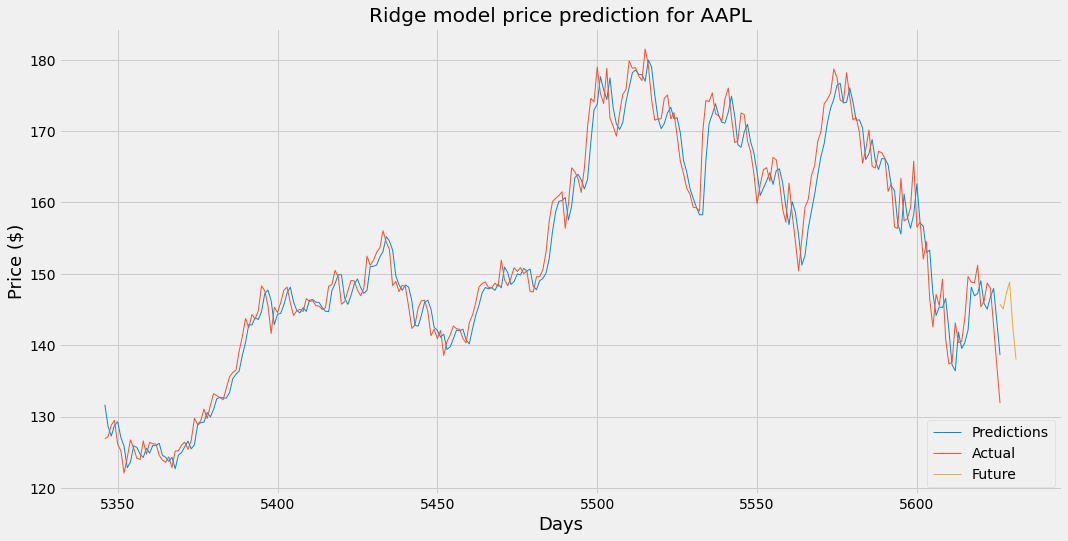

In [170]:
plt.figure(figsize=(16, 8))
plt.plot(df_final.Close_pred, linewidth = 1.0)
plt.plot(df_final.Close_actual, linewidth = 1.0)
plt.plot(df_final.Future, linewidth = 1.0)
plt.xlabel('Days', fontsize=18)
plt.ylabel('Price ($)', fontsize = 18)
plt.legend(['Predictions',  'Actual', 'Future'], loc='lower right')
plt.title('Ridge model price prediction for {}'.format(company))
plt.show()

Getting the root mean squared error (RMSE) which is the standard deviation of the prediction errors

In [171]:
print('Mean absolute sqaured error is: {}'.format(mean_squared_error(y_test, y_pred)))

Mean absolute sqaured error is: 8.503401763212365


Creating the value which is a correlation between real price and our model predicted price

In [172]:
corr_price, p = stats.pearsonr(df_pred_ridge.Close_actual.values, df_pred_ridge.Close_pred.values)
print("Correlation between actual price and predicted by our model price is: {}".format(corr_price))

Correlation between actual price and predicted by our model price is: 0.9820498259213808


# **Creating summarizing data frame**

In [173]:
df_pred_ridge['diff'] = df_pred_ridge.Close_actual - df_pred_ridge.Close_pred
df_pred_ridge['perc_diff'] = ((df_pred_ridge['diff']) / (df_pred_ridge['Close_pred']))*100
print(df_pred_ridge)

     Close_actual  Close_pred      diff perc_diff
5346    126.90815  131.653529 -4.745379 -3.604445
5347   127.156303  128.596196 -1.439893 -1.119701
5348   128.784225  127.261177  1.523049   1.19679
5349   129.470322  128.762042  0.708279  0.550068
5350   126.129387  129.262002 -3.132615 -2.423462
...           ...         ...       ...       ...
5622   148.710007  145.045405  3.664602  2.526521
5623   147.960007  146.769617   1.19039   0.81106
5624   142.639999  147.944688 -5.304689 -3.585589
5625   137.130005  143.355860 -6.225855 -4.342937
5626   131.880005  138.596644 -6.716639 -4.846177

[281 rows x 4 columns]


Final result summary

In [174]:
print('Model predicted for today close: {}, current price is: {}'.format(round(df_pred_ridge['Close_pred'].iat[-1], 2), round(df_pred_ridge['Close_actual'].iat[-1], 2)))


Model predicted for today close: 138.6, current price is: 131.88


In [175]:
print(df_final)

     Close_actual  Close_pred      Future
5346    126.90815  131.653529         NaN
5347   127.156303  128.596196         NaN
5348   128.784225  127.261177         NaN
5349   129.470322  128.762042         NaN
5350   126.129387  129.262002         NaN
...           ...         ...         ...
5627          NaN         NaN  145.054468
5628          NaN         NaN  147.313801
5629          NaN         NaN  148.832061
5630          NaN         NaN  142.545867
5631          NaN         NaN  138.006845

[286 rows x 3 columns]
